# Estimating Non-Mandatory Tour Frequency

This notebook illustrates how to re-estimate a single model component for ActivitySim.  This process 
includes running ActivitySim in estimation mode to read household travel survey files and write out
the estimation data bundles used in this notebook.  To review how to do so, please visit the other
notebooks in this directory.

# Load libraries

In [127]:
import os
import larch  # !conda install larch -c conda-forge # for estimation
import pandas as pd
import numpy as np
import activitysim
import datetime
activitysim.__version__

pd.options.display.max_columns = 150

We'll work in our `test` directory, where ActivitySim has saved the estimation data bundles.

In [128]:
os.chdir('C:\ABM3_dev\outputs')

In [129]:
def write_coeffs(segment):
    path = r'output\estimation_data_bundle\non_mandatory_tour_frequency'
    spec = pd.read_csv(os.path.join(path, f'non_mandatory_tour_frequency_SPEC.csv'))
    coefs = spec[segment].dropna()
    coefs_df = pd.DataFrame()
    coefs_df['coefficient_name'] = coefs
    coefs_df['value'] = 0.0
    coefs_df['constrain'] = 'F'
    coefs_df.loc[coefs_df['coefficient_name'] == 'coef_unavailable', 'value'] = -999
    coefs_df.loc[coefs_df['coefficient_name'] == 'coef_unavailable', 'constrain'] = 'T'
    # coefs_df.to_csv(os.path.join(path, segment, f'non_mandatory_tour_frequency_coefficients_{segment}.csv'), index=False)
    coefs_df.to_csv(os.path.join(r'C:\ABM3_dev\ABM\src\asim\configs\estimation', f'non_mandatory_tour_frequency_coefficients_{segment}.csv'), index=False)

# write_coeffs('PTYPE_FULL')
# write_coeffs('PTYPE_PART')
# write_coeffs('PTYPE_UNIVERSITY')
# write_coeffs('PTYPE_NONWORK')
# write_coeffs('PTYPE_RETIRED')
# write_coeffs('PTYPE_DRIVING')
# write_coeffs('PTYPE_SCHOOL')
# write_coeffs('PTYPE_PRESCHOOL')

In [130]:
# tours = pd.read_csv(r"C:\ABM3_dev\outputs\output_estimation\final_tours.csv")
# persons = pd.read_csv(r"C:\ABM3_dev\run_data\data_2z_series15\override_persons.csv")
# tours = pd.read_csv(r"C:\ABM3_dev\run_data\data_2z_series15\override_tours.csv")

C:\Users\davidh\AppData\Local\Temp\4\ipykernel_19368\4254469908.py:1: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  persons = pd.read_csv(r"C:\ABM3_dev\outputs\output\final_persons.csv")


<AxesSubplot: xlabel='age_binned'>

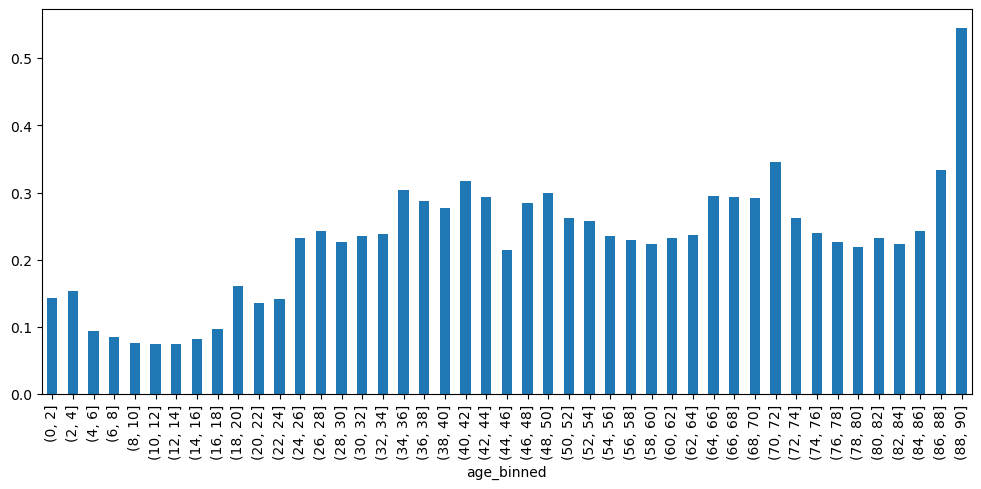

In [131]:
persons = pd.read_csv(r"C:\ABM3_dev\outputs\output\final_persons.csv")
nm_purposes = ['_escort', '_shopping', '_othmaint', '_eatout', '_social', '_othdiscr']
persons['total_indNM_tours'] = persons[nm_purposes].sum(axis=1)
persons['age_binned'], bins = pd.cut(persons.age, bins=np.arange(0,91,2), retbins=True)
persons.groupby(['age_binned']).total_indNM_tours.mean().plot(kind='bar', figsize=(12,5))
# persons.age_binned.value_counts()

# Load data and prep model for estimation

In [132]:
modelname = "nonmand_tour_freq"

from activitysim.estimation.larch import component_model
# model, data = component_model(modelname, return_data=True, condense_parameters=False, num_chunks=10)
model, data = component_model(modelname, return_data=True, condense_parameters=False, segment_subset=['PTYPE_RETIRED'], num_chunks=10)

ptype_for_display = 'PTYPE_RETIRED'

Loading EDB for PTYPE_RETIRED segment
Creating larch model for PTYPE_RETIRED
	 performing cv to ca step
x_ca data loaded from PTYPE_RETIRED_x_ca.fea - time elapsed 0.6342


The prototype model spec we are re-estimating has 210 rows for each person type, but the
accompanying dataset is not large enough to successfully estimate anywhere near than many
parameters. The `condense_parameters` option is activated here as a short cut to making
a model that can be estimated with stable parameter results.  When activated, it merges
parameters not only by name (i.e. when the same name appears twice it is the same parameter)
but also by value, so that if the initial value of any two parameters is identical
then they are treated as the same parameter.  Using "condense_parameters" in actual model
estimation efforts is ill advised and may generate confusing or unexpected results.

This component actually has a distinct choice model for each person type, so
instead of a single model there's a `dict` of models.

In [133]:
type(model)

dict

In [134]:
model.keys()

dict_keys(['PTYPE_RETIRED'])

# Review data loaded from the EDB

We can review the data loaded as well, similarly there is seperate data 
for each person type.

## Coefficients

In [135]:
data.coefficients[ptype_for_display]

,value,constrain
coefficient_name,,
coef_escorting_tour,0.0,F
coef_discretionary_tour,0.0,F
coef_shopping_tour,0.0,F
coef_maintenance_tour,0.0,F
coef_visiting_or_social_tour,0.0,F
...,...,...
coef_shopping_accessibility_shopping,0.0,F
coef_shopping_accessibility_maintenance,0.0,F
coef_othdiscr_accessibility_eating_out,0.0,F


## Utility specification

In [136]:
data.spec[ptype_for_display]

0               coef_escorting_tour
1           coef_discretionary_tour
2                coef_shopping_tour
3             coef_maintenance_tour
4      coef_visiting_or_social_tour
                   ...             
163                             NaN
164                             NaN
165                             NaN
166                             NaN
167                             NaN
Name: PTYPE_RETIRED, Length: 168, dtype: object

## Chooser data

In [137]:
data.chooser_data[ptype_for_display]

,person_id,model_choice,override_choice,household_id,PNUM,age,sex,pemploy,pstudent,is_student,ptype,school_zone_id,workplace_zone_id,free_parking_at_work,work_from_home,telecommute_frequency,day,educ,external_worker_identification,external_workplace_zone_id,transit_pass_subsidy,transit_pass_ownership,industry,cdap_activity,mandatory_tour_frequency,_escort,_shopping,_othmaint,_eatout,_social,_othdiscr,non_mandatory_tour_frequency,age_16_to_19,age_16_p,adult,male,female,has_non_worker,has_retiree,has_preschool_kid,has_driving_kid,has_school_kid,has_full_time,has_part_time,has_university,student_is_employed,nonstudent_to_school,is_preschool,is_gradeschool,is_highschool,is_university,school_segment,is_worker,is_fulltime_worker,is_parttime_worker,is_internal_worker,is_external_worker,home_zone_id,time_factor_work,time_factor_nonwork,naics_code,is_income_less25K,is_income_25K_to_60K,is_income_60K_to_120K,is_income_greater60K,is_income_greater120K,is_non_worker_in_HH,is_all_adults_full_time_workers,is_pre_drive_child_in_HH,is_out_of_home_worker,external_workplace_location_logsum,external_workplace_modechoice_logsum,school_location_logsum,school_modechoice_logsum,distance_to_school,...,openspaceparkpreserve,beachactive,budgetroom,economyroom,luxuryroom,midpriceroom,upscaleroom,hotelroomtotal,truckregiontype,district27,milestocoast,acres,effective_acres,land_acres,MicroAccessTime,remoteAVParking,refueling_stations,totint,duden,empden,popden,retempden,totintbin,empdenbin,dudenbin,PopEmpDenPerMi,TAZ,poe_id,external_work,external_nonwork,external_TAZ,external_MAZ,walk_dist_local_bus,walk_dist_premium_transit,ML_DIST,AVGTTS,PCTDETOUR,terminal_time,household_density,population_density,employment_density,density_index,is_cbd,tot_collegeenroll,preschool_target,is_parking_zone,num_hh_joint_tours,low_income,medium_low_income,medium_income,medium_high_income,high_income,max_time_window,log_max_time_window,num_person_joint_tours,num_person_joint_shop_tours,num_person_joint_maint_tours,num_person_joint_eatout_tours,num_person_joint_visit_tours,num_person_joint_othdiscr_tours,num_mandatory_tours,num_school_escort_tours,has_mandatory_tour,has_school_escort_tour,has_previous_tour,num_full_time_workers_not_self,num_part_time_workers_not_self,num_university_students_not_self,num_non_workers_not_self,num_retirees_not_self,num_driving_age_students_not_self,num_pre_driving_age_school_kids_not_self,num_pre_school_kids_not_self,retiredHh,num_travel_active_pre_drive_students
0,6,45,1,2,2,71,1,3,3,False,5,-1,-1,False,False,NaN,1,13,1,-1,0,0,NaN,N,NaN,0,0,0,0,0,1,1,False,True,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,0,False,False,False,False,False,19303,0.936449,0.508224,0,False,True,False,False,False,True,False,False,False,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,1,1,7.2567,33.7884,33.7884,33.7884,120,0,0,11,2.1970,2.5400,6.8756,1.2043,1,1,1,6025.9783,1260,NaN,0.0,0.0,NaN,NaN,0.560,1.000,7.2306,0.16124,0.20751,0.0,1.302222,4.321010,0.295960,0.241152,False,0,156,True,0,False,True,False,False,False,48,3.891820,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,10,68,0,5,1,82,1,3,3,False,5,-1,-1,False,False,NaN,1,13,1,-1,0,0,NaN,N,NaN,0,0,0,0,0,0,0,False,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,0,False,False,False,False,False,13161,0.334941,0.449265,0,False,True,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0,0,1,23,1.6830,6.8992,6.8992,6.8992,120,0,0,37,3.7989,0.9639,9.7925,0.0067,1,1,1,6884.0914,1465,NaN,0.0,0.0,NaN,NaN,0.700,1.000,5.3084,0.22792,0.00000,0.0,4.783163,14.059601,0.000000,0.000000,False,0,97,True,1,False,True,False,False,False,44,3.806662,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
2,11,59,0,5,2,79,2,3,3,False,5,-1,-1,False,False,NaN,1,13,1,-1,0,0,NaN,N,NaN,0,0,0,0,0,0,0,False,True,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,0,False,False,False

In [138]:
alt_df = data.alt_values[ptype_for_display]
alt_df.head()

,person_id,variable,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,...,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196
0,6,util_adult_18to24_eatout,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6,util_adult_18to24_escort,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,util_adult_18to24_othdiscr,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,util_adult_18to24_othmaint,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6,util_adult_18to24_shopping,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [139]:
df = data.chooser_data[ptype_for_display].copy()
alts = pd.read_csv(r"C:\ABM3_dev\outputs\output\estimation_data_bundle\non_mandatory_tour_frequency\non_mandatory_tour_frequency_alternatives.csv", index_col=0)
df = df.merge(alts, how='left', left_on='override_choice', right_index=True)

In [140]:
tour_counts = []
for col in ['escort','shopping','othmaint','eatout','social','othdiscr','tot_tours', 'num_mandatory_tours', 'num_joint_tours']:
    tmp = df[col].value_counts()
    tour_counts.append(tmp)

tour_counts = pd.concat(tour_counts, axis=1).fillna(0).astype(int)
tour_counts.loc['Total'] = tour_counts.sum(axis=0)
tour_counts

,escort,shopping,othmaint,eatout,social,othdiscr,tot_tours,num_mandatory_tours,num_joint_tours
0,3690,2909,2926,3510,3847,2417,449,3954,3217
1,206,977,947,444,107,1312,2444,0,638
2,58,68,81,0,0,225,822,0,99
3,0,0,0,0,0,0,192,0,0
4,0,0,0,0,0,0,42,0,0
5,0,0,0,0,0,0,5,0,0
Total,3954,3954,3954,3954,3954,3954,3954,3954,3954


In [141]:
pd.crosstab(df.tot_tours, df.income_segment)

income_segment,1,2,3,4
tot_tours,,,,
0,102,157,118,72
1,704,816,625,299
2,171,293,238,120
3,29,75,53,35
4,5,16,11,10
5,0,1,3,1


# Estimate

With the model setup for estimation, the next step is to estimate the model coefficients.  Make sure to use a sufficiently large enough household sample and set of zones to avoid an over-specified model, which does not have a numerically stable likelihood maximizing solution.  The prototype model spec we are re-estimating has 210 rows for each person type, but the accompanying dataset is not large enough to successfully estimate anywhere near than many parameters, so a short cut is applied by having one parameter only per unique existing parameter value.

In [142]:
for k, m in model.items():
    print(f"Person type {k} has {len(m.utility_ca)} utility terms and {len(m.pf)} unique parameters.")

Person type PTYPE_RETIRED has 47 utility terms and 47 unique parameters.


For future estimation work, parameters can be intelligently named and applied to match the model developer's desired structure (by using the same named parameter for multiple rows of the spec file).  If this is done, the "short cut" should be disabled by setting `condense_parameters=False` in the loading step above.

Larch has a built-in estimation methods including BHHH, and also offers access to more advanced general purpose non-linear optimizers in the `scipy` package, including SLSQP, which allows for bounds and constraints on parameters.  BHHH is the default and typically runs faster, but does not follow constraints on parameters.

In [143]:
for k, m in model.items():
    # m.estimate(method='SLSQP')
    m.estimate(method='BHHH', options={'maxiter':1500})

req_data does not request avail_ca or avail_co but it is set and being provided


,value,initvalue,nullvalue,minimum,maximum,holdfast,note,best
coef_age_80p_eatout,-0.509549,0.0,0.0,NaN,NaN,0,,-0.509549
coef_age_80p_escort,-0.536917,0.0,0.0,NaN,NaN,0,,-0.536917
coef_auto_deficient_iNM_tour_freq_1,-1.220305,0.0,0.0,NaN,NaN,0,,-1.220305
coef_auto_deficient_iNM_tour_freq_2,-1.596845,0.0,0.0,NaN,NaN,0,,-1.596845
coef_auto_deficient_iNM_tour_freq_3p,-1.741046,0.0,0.0,NaN,NaN,0,,-1.741046
coef_discretionary_tour,9.237927,0.0,0.0,NaN,NaN,0,,9.237927
coef_eating_out_tour,12.871516,0.0,0.0,NaN,NaN,0,,12.871516
coef_escorting_tour,13.238440,0.0,0.0,NaN,NaN,0,,13.238440
coef_has_joint_tours_and_iNM_tour_freq_1,-1.230172,0.0,0.0,NaN,NaN,0,,-1.230172
coef_has_joint_tours_and_iNM_tour_freq_3p,0.992153,0.0,0.0,NaN,NaN,0,,0.992153


### Estimated coefficients

In [144]:
model[ptype_for_display].parameter_summary()

,Value,Std Err,t Stat,Signif,Null Value
coef_age_80p_eatout,-0.510,0.196,-2.61,**,0.00
coef_age_80p_escort,-0.537,0.246,-2.18,*,0.00
coef_auto_deficient_iNM_tour_freq_1,-1.22,0.142,-8.58,***,0.00
coef_auto_deficient_iNM_tour_freq_2,-1.60,0.186,-8.58,***,0.00
coef_auto_deficient_iNM_tour_freq_3p,-1.74,0.283,-6.14,***,0.00
coef_discretionary_tour,9.24,4.54,2.04,*,0.00
coef_eating_out_tour,12.9,7.89,1.63,,0.00
coef_escorting_tour,13.2,6.63,2.00,*,0.00
coef_has_joint_tours_and_iNM_tour_freq_1,-1.23,0.135,-9.08,***,0.00
coef_has_joint_tours_and_iNM_tour_freq_3p,0.992,0.352,2.82,**,0.00


# Output Estimation Results

In [145]:
from activitysim.estimation.larch import update_coefficients
for k, m in model.items():
    result_dir = data.edb_directory/k/"estimated"
    update_coefficients(
        m, data.coefficients[k], result_dir,
        output_file=f"{modelname}_{k}_coefficients_revised_{datetime.datetime.now().strftime('%d_%m_%Y %H_%M_%S')}.csv",
        relabel_coef=data.relabel_coef.get(k),
    );

### Write the model estimation report, including coefficient t-statistic and log likelihood

In [146]:
for k, m in model.items():
    result_dir = data.edb_directory/k/"estimated"
    m.to_xlsx(
        result_dir/f"{modelname}_{k}_model_estimation_{datetime.datetime.now().strftime('%d_%m_%Y %H_%M_%S')}.xlsx", 
        data_statistics=True,
    )

c:\Users\davidh\.conda\envs\baydag_v2\lib\site-packages\larch\util\excel.py:523: FutureWarning: Use of **kwargs is deprecated, use engine_kwargs instead.
  xl = ExcelWriter(filename, engine='xlsxwriter_larch', model=model, **kwargs)
c:\Users\davidh\.conda\envs\baydag_v2\lib\site-packages\larch\util\excel.py:478: FutureWarning: path is not part of the public API, usage can give unexpected results and will be removed in a future version
  if self.path is not None:
c:\Users\davidh\.conda\envs\baydag_v2\lib\site-packages\larch\util\excel.py:496: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  super().save()


# Next Steps

The final step is to either manually or automatically copy the `*_coefficients_revised.csv` file to the configs folder, rename it to `*_coefficients.csv`, and run ActivitySim in simulation mode.

In [147]:
# result_dir = data.edb_directory/'PTYPE_FULL'/"estimated"
# pd.read_csv(result_dir/f"{modelname}_PTYPE_FULL_coefficients_revised.csv")